# Решение интегрального уравнения первого рода.

Дано уравнение (22) (см. методичку стр. 23). 

In [66]:
import numpy as np
import seaborn as sns
import scipy.integrate as integrate

from tqdm import tqdm
from typing import Tuple, Callable, List
import itertools

<IPython.core.display.Javascript object>

In [2]:
sns.set(rc={'figure.figsize':(16, 9)})

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
OneArgFunc = Callable[[float], float]
TwoArgFunc = Callable[[float, float], float]

<IPython.core.display.Javascript object>

In [5]:
# Вариант 34


def K(x: float, s: float) -> float:
    return 1 / (3 + s * x)

<IPython.core.display.Javascript object>

## Первый способ
Сводим его к СЛАУ (24), для её решения применяем метод регуляризации. 

Для отладки использовать функции $z_1(s) = 1, z_2(s)=s(1-s)$ по которым строятся соответствующие правые части   

In [6]:
def z1(s: float) -> float:
    return 1


def u1(x: float) -> float:
    if abs(x) < 1e-12:
        return 1 / 3
    return np.log((x / 3) + 1) / x


def z2(s: float) -> float:
    return s * (1 - s)


def u2(x: float) -> float:
    if abs(x) < 1e-10:
        return 1 / 18
    numerator = x * (x + 6) + 6 * (x + 3) * np.log(3 / (x + 3))
    denominator = 2 * x ** 3
    return numerator / denominator

<IPython.core.display.Javascript object>

In [7]:
def create_net(n: int) -> Tuple[np.ndarray, float]:
    X = np.linspace(0, 1, num=n + 1)
    h = X[1] - X[0]
    return (X + h / 2)[:-1], h

<IPython.core.display.Javascript object>

In [8]:
def solve_equation(
    kernel: TwoArgFunc, right: OneArgFunc, n: int, alpha
) -> Tuple[np.ndarray, np.ndarray]:
    net, A = create_net(n)
    S = np.identity(n)
    u = np.zeros(n)
    for j, el_j in enumerate(net):
        u[j] = right(el_j)
        for k, el_k in enumerate(net):
            S[j][k] = kernel(el_j, el_k)

    S_star = np.conjugate(S)
    left_side = A ** 2 * S_star @ S + alpha * np.identity(n)
    right_side = A * S_star @ u
    return net, np.linalg.solve(left_side, right_side)

<IPython.core.display.Javascript object>

In [9]:
def verify_solution(net: np.ndarray, solution: np.ndarray, right: OneArgFunc):
    actual = [
        integrate.quad(lambda s: solution[i] * K(x, s), 0, 1)[0]
        for i, x in enumerate(net)
    ]
    expected = [right(x) for x in net]
    return np.abs(1 - np.linalg.norm(actual) / np.linalg.norm(expected))

<IPython.core.display.Javascript object>

In [88]:
def search_alpha(
    kernel: TwoArgFunc,
    right: OneArgFunc,
    alpha_edges: Tuple = None,
    precision: int = 100,
    n: int = 1000,
):
    if alpha_edges is None:
        alpha_edges = (-20.0, 0)

    alpha_space = np.logspace(alpha_edges[0], alpha_edges[1], precision)
    best_alpha = 0
    best_error = np.inf
    error_trace = []
    for alpha in tqdm(alpha_space):
        net, solution = solve_equation(kernel, right, n, alpha)
        error = verify_solution(net, solution, right)
        if error < best_error:
            best_error = error
            best_alpha = alpha
        error_trace.append(error)

    ax = sns.lineplot(x=alpha_space, y=error_trace)
    ax.set(
        yscale="log",
        ylabel="Относительная погрешность",
        xscale="log",
        xlabel="Параметр alpha",
    )
    return best_alpha

<IPython.core.display.Javascript object>

100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.61it/s]


1.2915496650148826e-09

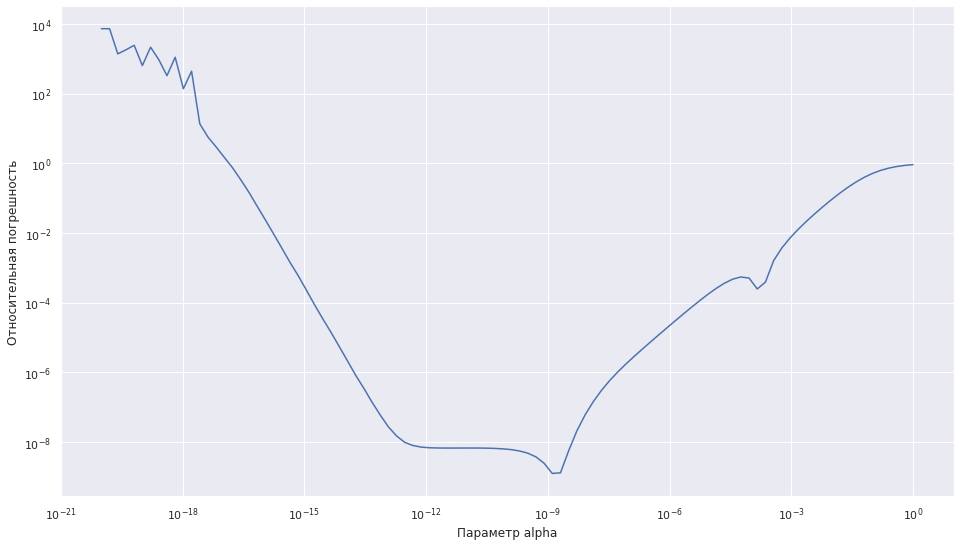

<IPython.core.display.Javascript object>

In [89]:
search_alpha(K, u1)

100%|█████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


2.1544346900318867e-07

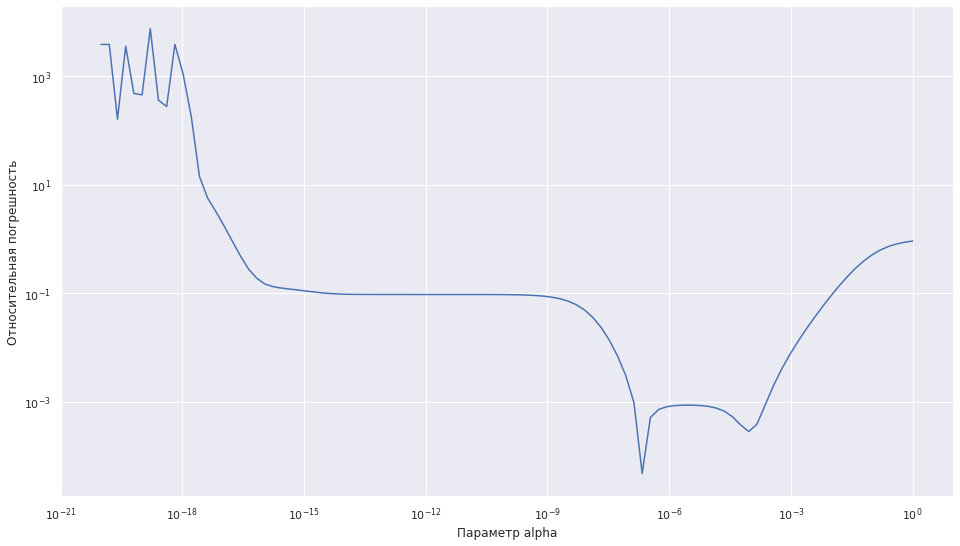

<IPython.core.display.Javascript object>

In [90]:
search_alpha(K, u2)

In [102]:
import time

times = []
n_space = [10, 50, 100, 500, 1000, 5000, 10_000]
for n in n_space:
    start = time.perf_counter()
    solve_equation(K, u1, n, 1e-9)
    elapsed = time.perf_counter()
    times.append(elapsed - start)

<IPython.core.display.Javascript object>

In [103]:
dict(zip(n_space, times))

{10: 0.0002621749990794342,
 50: 0.002975887000502553,
 100: 0.01850851799827069,
 500: 0.1845023969981412,
 1000: 0.5765799040018464,
 5000: 14.685477353999886,
 10000: 65.36945196500164}

<IPython.core.display.Javascript object>

Несовпадение норм 5.486305298951777e-09%


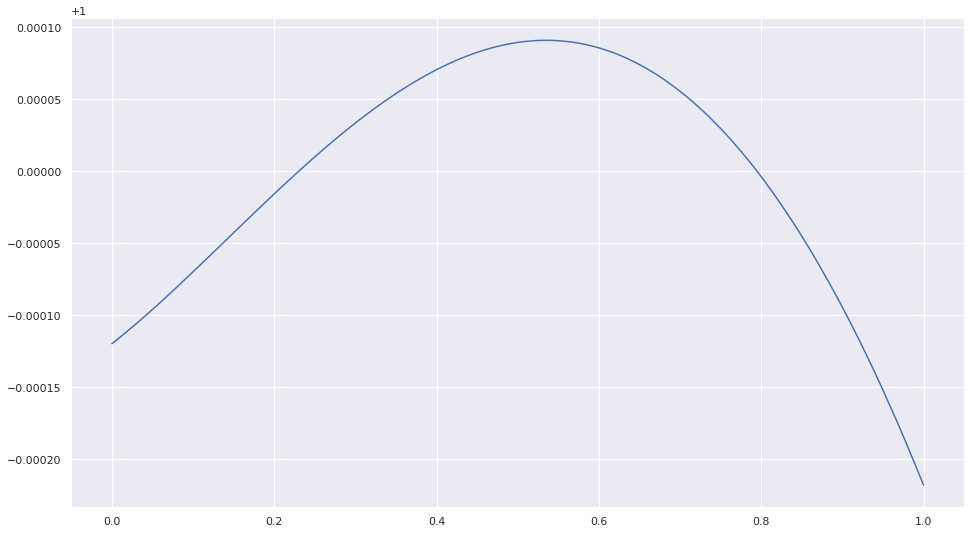

<IPython.core.display.Javascript object>

In [104]:
net, solution = solve_equation(K, u1, 10_000, 1.63e-9)

sns.lineplot(x=net, y=solution)
# sns.lineplot(x=net, y=np.ones(10_000))

print(f"Несовпадение норм {verify_solution(net, solution, u1):3}%")

## Второй способ
Решается уравнение (27) с однородными граничными условиями $z(0)=z(1)=0$ (см. стр. 26). 
Уравнение Эйлера (32), его аппроксимация приведена на стр. 27, в итоге приходим к СЛАУ, 
для решения которых применяется первый способ и отлаживается на тех же функциях. 

In [13]:
def K1(s: float, t: float) -> float:
    if abs(s - t) < 10 ** (-15):
        return 1 / (3 * t + 9)
    numerator = np.log(s + 3) - np.log(t + 3)
    denominator = 3 * (s - t)
    return numerator / denominator

<IPython.core.display.Javascript object>

In [78]:
z_0 = 0
z_1 = 0

<IPython.core.display.Javascript object>

Уравнение из методички представимо в виде: $\alpha R + S = U$

Где $R$ трехдиагональная матрица, $S$ матрица похожая на предыдущую матрицу $S$, а $U$ вектор значений правой части

In [16]:
def set_diag(A, val, offset=0):
    offset = -offset
    if not isinstance(val, np.ndarray):
        val = np.full(A.shape[0] - abs(offset), val)
    indices = np.diag_indices_from(A)
    indices = indices[0] + offset, indices[1]
    if offset > 0:
        indices = indices[0][:-offset], indices[1][:-offset]
    else:
        indices = indices[0][-offset:], indices[1][-offset:]

    A[indices] = val

<IPython.core.display.Javascript object>

In [76]:
class EquationSolver:
    def __init__(
        self, n: int, alpha: float, right: OneArgFunc, p: OneArgFunc, r: OneArgFunc
    ):
        self.N = n
        self.alpha = alpha
        self.right = right
        self.p = p
        self.r = r

        self.net = np.linspace(0, 1, n)
        self.h = self.net[1] - self.net[0]
        self.solution = self.solve_equation()

    def p_left(self, i):
        return self.p((self.net[i] + self.net[i - 1]) / 2)

    def p_right(self, i):
        return self.p((self.net[i] + self.net[i + 1]) / 2)

    def generate_R(self) -> np.ndarray:
        upper_rim = -np.array([self.p_left(i) for i in range(2, self.N - 1)]) / (
            self.h ** 2
        )

        lower_rim = -np.array([self.p_right(i) for i in range(1, self.N - 2)]) / (
            self.h ** 2
        )

        diagonal = np.array(
            [
                (self.p_left(i) + self.p_right(i)) / (self.h ** 2) + self.r(self.net[i])
                for i in range(1, self.N - 1)
            ]
        )

        R = np.zeros((self.N - 2, self.N - 2))
        set_diag(R, diagonal)
        set_diag(R, lower_rim, offset=-1)
        set_diag(R, upper_rim, offset=1)

        return R

    def generate_S(self) -> np.ndarray:
        S = np.identity(self.N - 2)
        for j, el_j in enumerate(self.net[1:-1]):
            for k, el_k in enumerate(self.net[1:-1]):
                S[j][k] = K1(el_j, el_k)
        return S

    def generate_U(self) -> np.ndarray:
        u = []
        for i, el in enumerate(self.net[1:-1]):
            u.append(self.right(el))
        return np.array(u)

    def solve_equation(self):
        R = self.generate_R()
        S = self.generate_S()
        U = self.generate_U()
        solution = np.linalg.solve(self.alpha * R + self.h * S, U)
        return np.array([z_0, *solution, z_1])

<IPython.core.display.Javascript object>

In [71]:
def search_parameters_for_second(
    right: OneArgFunc,
    alpha_edges: Tuple = None,
    alpha_precision: int = 100,
    p_list: List[OneArgFunc] = None,
    r_list: List[OneArgFunc] = None,
):
    if alpha_edges is None:
        alpha_edges = (-20.0, 0)
    alpha_space = np.logspace(alpha_edges[0], alpha_edges[1], alpha_precision)

    if p_list is None:
        p_dict = {"1": lambda x: 1, "x": lambda x: x, "x^2": lambda x: x ** 2}
    if r_list is None:
        r_dict = {"1": lambda x: 1, "x": lambda x: x, "x^2": lambda x: x ** 2}

    best_params = None
    best_error = np.inf
    combinations = itertools.product(alpha_space, p_dict.keys(), p_dict.keys())
    for conf in tqdm(list(combinations)):
        alpha, p_key, r_key = conf
        p, r = p_dict[p_key], r_dict[r_key]
        solver = EquationSolver(n=1000, alpha=alpha, right=right, p=p, r=r)
        net, solution = solver.net, solver.solution
        error = verify_solution(net, solution, right)
        if error < best_error:
            best_error = error
            best_params = conf
    return best_params, best_error

<IPython.core.display.Javascript object>

In [73]:
search_parameters_for_second(u1)

100%|█████████████████████████████████████████| 900/900 [37:41<00:00,  2.51s/it]


((0.09770099572992247, 'x', 'x^2'), 0.0025200029553702485)

<IPython.core.display.Javascript object>

In [105]:
times = []
n_space = [10, 50, 100, 500, 1000, 5000, 10_000]
for n in n_space:
    start = time.perf_counter()
    EquationSolver(n, 0.0977, p=lambda x: x, r=lambda x: x ** 2, right=u1)
    elapsed = time.perf_counter()
    times.append(elapsed - start)
dict(zip(n_space, times))

{10: 0.0005503300017153379,
 50: 0.007384438002191018,
 100: 0.044256492001295555,
 500: 0.6620176680007717,
 1000: 2.517906421999214,
 5000: 63.455261134000466,
 10000: 267.3843905549984}

<IPython.core.display.Javascript object>

<AxesSubplot:>

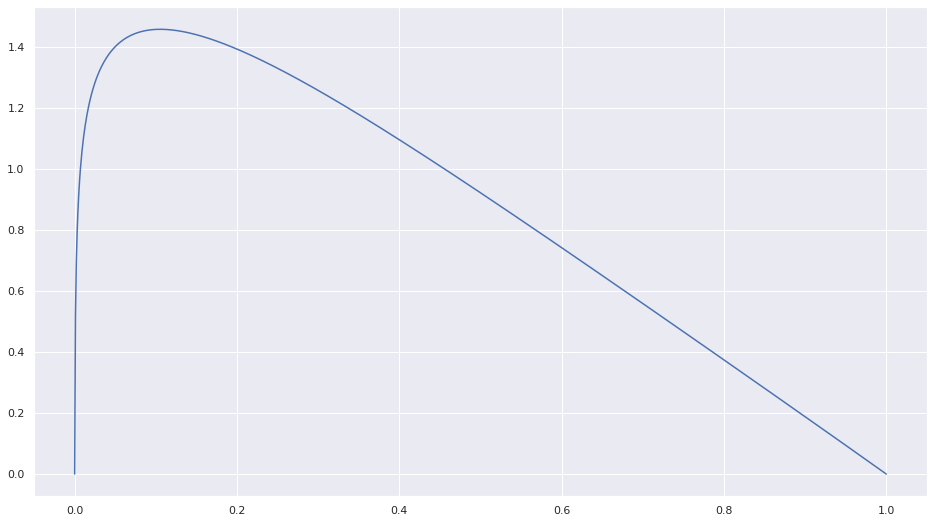

<IPython.core.display.Javascript object>

In [79]:
solver = EquationSolver(1000, 0.0977, p=lambda x: x, r=lambda x: x ** 2, right=u1)
sns.lineplot(x=solver.net, y=solver.solution)